In [1]:
from fastai.tabular import *
from sklearn.model_selection import train_test_split

from fastai_bayesian.custom_dropout import CustomDropout, switch_custom_dropout, convert_layers
from fastai_bayesian.metrics import (entropy, BALD, uncertainty_best_probability,
                      get_preds_sample, plot_hist_groups, top_k_uncertainty)

import seaborn as sns

In [2]:
class ActiveLearner:
    def __init__(self,path,train_df,test_df,acq_df,data_params:dict,learn_params:dict,
                 acq_fn=None,label_fn=None):
        """Initialiaze the Learner with the train and test data, and create it with the given params. 
        data_params are the parameters of the TabularDatabunch.
        learn_params are the parameters of the tabular learner other than the Databunch.
        acq_fn is the acq_fn to use. Its signature is :
        acq_fn(learn:Learner,k)
        
        label_fn()
        
        """
        self.path = path
        self.data_params = data_params
        self.learn_params = learn_params
        
        # We store the functions we will use
        self.acq_fn = acq_fn
        self.label_fn = label_fn
        
        # Create the Learner
        self.add_learn(train_df,acq_df)
        
    def add_learn(self,train_df,acq_df,valid_pct = 0.2):
        train_n = len(train_df)
        valid_size = int(valid_pct * train_n)
        valid_idx = np.random.choice(train_n,valid_size,replace=False)

        # Create a Learner 
        path = self.path
        data_params = self.data_params
        data = TabularDataBunch.from_df(path, df=train_df, valid_idx=valid_idx, test_df=acq_df,**data_params)
        
        learn_params = self.learn_params
        learn = tabular_learner(data,**learn_params)
        
        # Add the Custom Dropout to do MC Dropout
        get_args = lambda dp : {"p" : dp.p}
        convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)
        switch_custom_dropout(learn.model,True)
        
        self.learn = learn
        self.acq_df = acq_df
        
    def fit(self,n_epoch,lr):
        """Train the model using one cycle policy and with the training params"""
        n_epoch = listify(n_epoch)
        lr = listify(lr)
        
        for n,l in zip(n_epoch,lr):
            self.learn.fit_one_cycle(n, l)
    
    def inspect(self):
        """Inspect the results of the learning"""
        pass
    
    def acquire(self,k):
        """Get indexes of the k most interesting labels to acquire from the test set"""
        idx = self.acq_fn(self.learn,self.acq_df,k)
        
        return idx
    
    def validate(self,metric,test_df,MC_dropout=False):
        learn = self.learn
        cat_names = self.data_params["cat_names"]
        dep_var = self.data_params["dep_var"]
        
        test_data = (TabularList.from_df(test_df, path=path, cat_names=cat_names))
        
        c2i = self.learn.data.train_ds.y.c2i
        y = test_df[dep_var].map(c2i).values
        y = torch.tensor(y)
        
        learn.data.add_test(test_data)
        
        if MC_dropout:
            preds = get_preds_sample(learn,DatasetType.Test)
            pred = preds.mean(dim=0)
        else:
            pred,_ = learn.get_preds(DatasetType.Test)
        
        score = metric(pred,y)
        return score
        
    def label(self,idx):
        """Label the indexes of the """
        df_to_label = self.acq_df.iloc[idx]        
        labeled_df = self.label_fn(df_to_label)
        return labeled_df
    
    @classmethod
    def transfer_rows(cls,train_df,acq_df,idx):
        """Transfer the rows of the test_df to the train_df"""
        rows = acq_df.iloc[idx]

        train_df = pd.concat([train_df,rows])
        acq_df = acq_df.drop(acq_df.index[idx])
        
        return train_df, acq_df

In [29]:
# Acquisition functions 
def get_top_samples(learn,acq_df,k,metric):
    preds,_ = get_preds_sample(learn,DatasetType.Test)
    scores = metric(preds)
    d = dict(zip(np.arange(len(scores)),scores))
    idx = sorted(d,key = d.get,reverse=True)[:k]
    
    return idx

def get_random_idx(learn,acq_df,k):
    idx = np.random.choice(np.arange(len(acq_df)),k,replace=False)
    return idx

top_bald = partial(get_top_samples,metric=BALD)
top_entropy = partial(get_top_samples,metric=entropy)

In [30]:
path = untar_data(URLs.ADULT_SAMPLE)
path

PosixPath('/home/danywin/.fastai/data/adult_sample')

In [31]:
df = pd.read_csv(path/'adult.csv')
df.dropna(how="any",inplace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
5,20,Private,63210,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,15,United-States,<50k
8,46,Private,328216,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>=50k
21,26,Private,746432,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,Black,Male,0,0,48,United-States,<50k


In [32]:
# get_args = lambda dp : {"p" : dp.p}
# convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)

procs = [FillMissing, Categorify, Normalize]
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

data_params = {
    "procs":procs, 
    "cat_names":cat_names,
    "dep_var":dep_var
}

learn_params = {
    "layers":[200,100],
    "ps":[0.10,0.05],
    "emb_szs":{'native-country': 10},
    "metrics":accuracy
}

In [38]:
init_train_df, test_df = train_test_split(df,test_size=0.9,random_state=42)
init_acq_df, test_df = train_test_split(test_df,train_size=0.8,random_state=42)
train_n = len(init_train_df)

label_fn = lambda x : x

In [39]:
n_runs = 5
n_cycle = 50
k = 10
outputs = []
acq_fn = get_random_idx
acq_name= "random"

train_df = init_train_df.copy()
acq_df = init_acq_df.copy()

active_learn = ActiveLearner(path,train_df,test_df,acq_df,data_params,learn_params,
                                 acq_fn=acq_fn,label_fn=label_fn)
for i in range(n_cycle):
    active_learn.fit(5,1e-2)

    score = active_learn.validate(accuracy,test_df).item()

    idx = active_learn.acquire(k=k)
    labeled_df = active_learn.label(idx)

    train_df, acq_df = active_learn.transfer_rows(train_df,acq_df,idx)
    active_learn.add_learn(train_df,acq_df)

    output = {"i":i,"score":score,"acq_name":acq_name}
    outputs.append(output)

Current active : True
Switching to : True
Current active : True
Switching to : True
Current active : True
Switching to : True


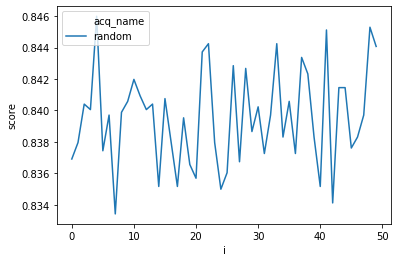

In [41]:
data = pd.DataFrame(outputs)
sns.lineplot(x="i",y="score",data=data,hue="acq_name")

In [8]:
n_runs = 5
n_cycle = 10
k = 64
outputs = []
acq_fn = top_bald
acq_name= "bald"

for t in range(n_runs):
    train_df = init_train_df.copy()
    acq_df = init_acq_df.copy()

    active_learn = ActiveLearner(path,train_df,test_df,acq_df,data_params,learn_params,
                                 acq_fn=acq_fn,label_fn=label_fn)
    for i in range(n_cycle):
        active_learn.fit(5,1e-2)

        score = active_learn.validate(accuracy,test_df).item()

        idx = active_learn.acquire(k=k)
        labeled_df = active_learn.label(idx)

        train_df, acq_df = active_learn.transfer_rows(train_df,acq_df,idx)
        active_learn.add_learn(train_df,acq_df)
        
        output = {"i":i,"score":score,"acq_name":acq_name}
        outputs.append(output)

Current active : True
Switching to : True
Current active : True
Switching to : True
Current active : True
Switching to : True


In [9]:
results = pd.DataFrame(outputs)

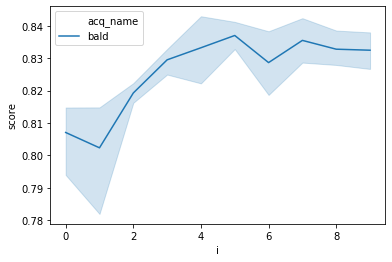

In [10]:
import seaborn as sns

sns.lineplot(x="i",y="score",hue="acq_name",data=results)

In [11]:
results.to_csv("results.csv",index=None)

In [12]:
n_runs = 5
n_cycle = 10
k = 64
outputs = []
acq_fn = top_entropy
acq_name= "entropy"

for t in range(n_runs):
    train_df = init_train_df.copy()
    acq_df = init_acq_df.copy()

    active_learn = ActiveLearner(path,train_df,test_df,acq_df,data_params,learn_params,
                                 acq_fn=acq_fn,label_fn=label_fn)
    for i in range(n_cycle):
        active_learn.fit(5,1e-2)

        score = active_learn.validate(accuracy,test_df).item()

        idx = active_learn.acquire(k=k)
        labeled_df = active_learn.label(idx)

        train_df, acq_df = active_learn.transfer_rows(train_df,acq_df,idx)
        active_learn.add_learn(train_df,acq_df)
        
        output = {"i":i,"score":score,"acq_name":acq_name}
        outputs.append(output)

Current active : True
Switching to : True
Current active : True
Switching to : True
Current active : True
Switching to : True


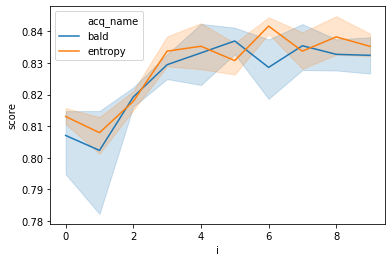

In [13]:
new_results = pd.DataFrame(outputs)
results = pd.concat([results,new_results])
sns.lineplot(x="i",y="score",hue="acq_name",data=results)

In [14]:
results.to_csv("results.csv",index=None)

In [15]:
n_runs = 5
n_cycle = 10
k = 64
outputs = []
acq_fn = get_random_idx
acq_name= "random"

for t in range(n_runs):
    train_df = init_train_df.copy()
    acq_df = init_acq_df.copy()

    active_learn = ActiveLearner(path,train_df,test_df,acq_df,data_params,learn_params,
                                 acq_fn=acq_fn,label_fn=label_fn)
    for i in range(n_cycle):
        active_learn.fit(5,1e-2)

        score = active_learn.validate(accuracy,test_df).item()

        idx = active_learn.acquire(k=k)
        labeled_df = active_learn.label(idx)

        train_df, acq_df = active_learn.transfer_rows(train_df,acq_df,idx)
        active_learn.add_learn(train_df,acq_df)
        
        output = {"i":i,"score":score,"acq_name":acq_name}
        outputs.append(output)

Current active : True
Switching to : True
Current active : True
Switching to : True
Current active : True
Switching to : True


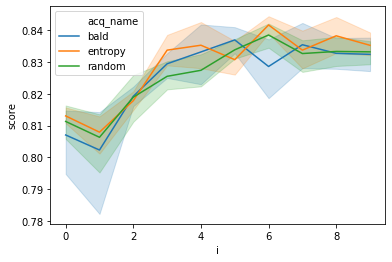

In [16]:
new_results = pd.DataFrame(outputs)
results = pd.concat([results,new_results])
sns.lineplot(x="i",y="score",hue="acq_name",data=results)

In [17]:
results.to_csv("results.csv",index=None)